# Deep Ensemble For Uncertainty Predictions

# Import

In [24]:
# system
import sys
import os 
import time

# data
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import itertools

# deep learning 
import torch.backends.cudnn as cudnn
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader 
import torchvision.transforms as txf
import kornia.augmentation as k

# custom helpers
import trainer
import metrics
import process
import models

# for formatting
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

# Notebook Toggles

In [2]:
COMPUTE_DISTRIBUTION = False
MODEL_ZOO = True
MODEL_TYPE = ["RES", "DENSE"][0]

## Hyperparameters 

In [3]:
device = torch.device('cuda:0')
epochs = 30
learning_rate = 3e-4
weight_decay = 1e-5
step_period = 3
lr_decay = 0.95
num_workers = 6
batch_size = 128

# Data

Data is provided by "The ISIC 2020 Challenge". The dataset is annotated for binary classification of skin lesions for melanoma detection. More information may be found at "https://challenge2020.isic-archive.com/"

Data is sources from 2000 patients and includes 33,126 dermoscopic training images

## Loading and Statistics

In [4]:
def toPath(root, image_id):
    return os.path.join(root, image_id + '.npy')

def toLabel(key, mapping):
    return mapping[key]

### HAM

In [5]:
# paths
ham_path = '/usr/local/faststorage/ezimmer/data/'

# parse data
metadata = pd.read_csv('./data/HAM/metadata.csv')
headers = metadata.head()

# verify data
label_mapping = {label : idx for idx, label in enumerate(sorted(np.unique(metadata['dx'])))}
data_file = {ID : {'image' : None, 'label' : None} for ID in metadata['image_id']}

for ID in metadata['image_id']:
    data_file[ID]['image'] = toPath(ham_path, ID)
    data_file[ID]['label'] = toLabel(metadata[metadata['image_id'] == ID]['dx'].values[0], label_mapping)

# get class distribution
class_counts = {idx : 0 for idx in range(len(np.unique(metadata['dx'])))}
for ID in data_file.keys():
    class_counts[data_file[ID]['label']] += 1
    
ncls = len(class_counts.keys())

In [6]:
print("HAM 10000 Metadata")
print('------------------------------------------------------------------')
print(headers, '\n')
print("Number of Classes")
print(ncls, '\n')
print('Unique Labels')
print(label_mapping, '\n')
print("Class Balance")
print(class_counts)

HAM 10000 Metadata
------------------------------------------------------------------
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear 

Number of Classes
7 

Unique Labels
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6} 

Class Balance
{0: 327, 1: 514, 2: 1099, 3: 115, 4: 1113, 5: 6705, 6: 142}


In [7]:
if COMPUTE_DISTRIBUTION: 
    ys, xs = [], []
    for ID in data_file.keys():
        img = cv.imread(data_file[ID]['image'])
        y, x, _ = img.shape
        ys.append(y)
        xs.append(x)
    
    print("Dataset Image Size Distribution")
    print("Num Patients", len(ys), len(xs))
    print("Unique Values", np.unique(ys), np.unique(xs))
    plt.scatter(y,x)
    plt.title("Image dimensions")
    plt.show()

## Experiment, Dataset, Dataloader

### Augmentations

In [8]:
train_augmentations = process.Transformer()
train_augmentations.add(k.RandomHorizontalFlip())
train_augmentations.add(k.RandomVerticalFlip())
train_augmentations.add(k.RandomRotation(15))
train_augmentations.add(k.ColorJitter(0.1, 0.1, 0.1))
train_augmentations.add(txf.Lambda(lambda x: x.squeeze()))
train_txf = train_augmentations.transforms()

Since the dataset is imbalanced, partition train/validation/test by number of classes and then wrap in an oversampler

In [9]:
# generate partitioned exp
partitioned_data = process.generateExperiment(data_file, ncls)
merged_data = process.restructureExperiments(partitioned_data)

# generate datasets
train_set = process.SkinSet(merged_data['train'])
val_set = process.SkinSet(merged_data['validation'])
test_set = process.SkinSet(merged_data['test'])

# Loaders
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

# Model

Randomly initialized ResNet-50/18/34

In [10]:
def init_weights(m):
        if (type(m) == nn.Conv2d or type(m) == nn.Linear):
            nn.init.kaiming_normal_(m.weight)

if MODEL_ZOO: 
    
    def generateModel(n_cls, model_type, init=None, device=None):
        if model_type == 'RES':
            model = torchvision.models.resnet18(pretrained=True)
            model.fc.out_features=n_cls
        
        elif model_type == 'DENSE':
            model = torchvision.models.densenet121(pretrained=True)
            model_lin = model.classifier.in_features
            model.classifier = nn.Linear(model_lin, n_cls)

        if init is not None:
            model.apply(init)

        if device is not None:
            model = model.to(device)

        return model

    model = generateModel(ncls, model_type=MODEL_TYPE, init=None, device=device)
    
else:
    basic_config = ([3, 32, 64, 128, 256], 1, True, 0.15, 7)
    model = models.BasicCNN(*basic_config).to(device)
    model.apply(init_weights)

# Optimization and Criteria

Optimizer: AdamW for super convergence and fast training

Scheduler: Step LR decay 

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_period, lr_decay)
criterion = nn.CrossEntropyLoss().to(device)

# Metrics and Aggregation

In [12]:
# Metric storage
train_stats = metrics.Aggregator()
val_stats = metrics.Aggregator()
test_stats = metrics.Aggregator()

# add stats
train_stats.addStat('loss')
val_stats.addStat('loss')
train_stats.addStat('acc', accuracy_score)
val_stats.addStat('acc', accuracy_score)

# Training 

Epoch: 1
--------------------------------
Time: 59.37415885925293
Training Loss:        1.3467706
Validation Loss:      0.67545253
Training Accuracy:    0.7107965931863728
Validation Accuracy:  0.7675350701402806 

Epoch: 2
--------------------------------
Time: 59.15791845321655
Training Loss:        0.52996457
Validation Loss:      0.5261237
Training Accuracy:    0.8093687374749499
Validation Accuracy:  0.8026052104208417 

Epoch: 3
--------------------------------
Time: 59.312318086624146
Training Loss:        0.4591665
Validation Loss:      0.57260734
Training Accuracy:    0.8355460921843687
Validation Accuracy:  0.7955911823647295 

Epoch: 4
--------------------------------
Time: 59.239418029785156
Training Loss:        0.4112609
Validation Loss:      0.5497164
Training Accuracy:    0.8466933867735471
Validation Accuracy:  0.8046092184368737 

Epoch: 5
--------------------------------
Time: 59.30732297897339
Training Loss:        0.3735264
Validation Loss:      0.48335767
Training

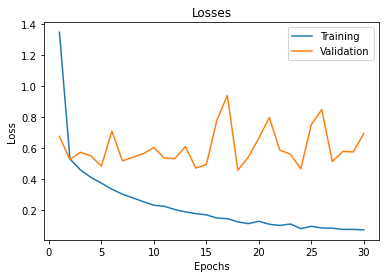

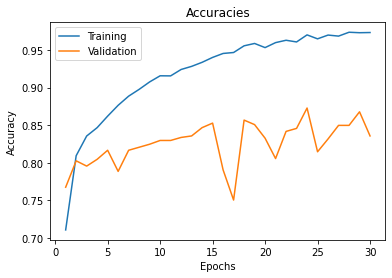

In [13]:
best_stat = 0
best_model = None
for epoch in range(epochs):
    
    t = time.time()
    
    # train
    preds, labels, t_loss = trainer.train(model, criterion, optimizer, scheduler, train_loader, device, train_txf)
    train_stats.logStat('loss', (t_loss,))
    train_stats.logStat('acc', (labels, preds))
    
    # validate
    preds, labels, v_loss = trainer.evaluate(model, criterion, optimizer, scheduler, val_loader, device)
    val_stats.logStat('loss', (v_loss,))
    val_stats.logStat('acc', (labels, preds))
    
    if val_stats.getStats('acc')[-1] > best_stat:
        best_stat = val_stats.getStats('acc')[-1]
        best_model = model.state_dict()
    
    t = time.time() - t
        
    print("Epoch:", epoch+1)
    print("--------------------------------")
    print("Time:", t)
    print("Training Loss:       ", t_loss)
    print("Validation Loss:     ", v_loss)
    print("Training Accuracy:   ", train_stats.getStats('acc')[-1])
    print("Validation Accuracy: ", val_stats.getStats('acc')[-1], '\n')
    
    
metrics.Plotter.plot(train_stats.getStats('loss'), val_stats.getStats('loss'), 'Epochs', 'Loss', 'Losses')
metrics.Plotter.plot(train_stats.getStats('acc'), val_stats.getStats('acc'), 'Epochs', 'Accuracy', 'Accuracies')

In [16]:
if not os.path.exists('./ensembles'):
    os.mkdir('./ensembles')

In [19]:
with open('exp.pickle', 'wb') as handle:
    pickle.dump(merged_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
torch.save(best_model, os.path.join('./ensembles', 'model_' + str(0) + '.pth.tar'))

# Testing

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
model.load_state_dict(best_model)
preds, labels, _ = trainer.evaluate(model, criterion, optimizer, scheduler, test_loader, device, )
test_acc = accuracy_score(labels, preds)
conf_mat = confusion_matrix(labels, preds)
print("Test Accuracy: ", test_acc)
print(conf_mat)

Test Accuracy:  0.8102613746369797
[[ 15   2   7   0  12   3   0]
 [  0  37   3   0  15   0   0]
 [  2   1  84   0  22   9   0]
 [  1   0   0   8   6   1   0]
 [  0   0   4   0 100  10   0]
 [  0   4   7   0  85 578   1]
 [  0   0   0   0   0   1  15]]


# Ensemble 

In [27]:
n_ensembles = 25

In [ ]:
for idx in range(1, n_ensembles):
    model = generateModel(ncls, MODEL_TYPE, None, device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_period, lr_decay)
    criterion = nn.CrossEntropyLoss().to(device)
    train_stats = metrics.Aggregator()
    val_stats = metrics.Aggregator()
    test_stats = metrics.Aggregator()
    train_stats.addStat('loss')
    val_stats.addStat('loss')
    train_stats.addStat('acc', accuracy_score)
    val_stats.addStat('acc', accuracy_score)
    
    best_stat = 0
    best_model = None
    for epoch in range(epochs):

        t = time.time()

        # train
        preds, labels, t_loss = trainer.train(model, criterion, optimizer, scheduler, train_loader, device, train_txf)
        train_stats.logStat('loss', (t_loss,))
        train_stats.logStat('acc', (labels, preds))

        # validate
        preds, labels, v_loss = trainer.evaluate(model, criterion, optimizer, scheduler, val_loader, device)
        val_stats.logStat('loss', (v_loss,))
        val_stats.logStat('acc', (labels, preds))

        if val_stats.getStats('acc')[-1] > best_stat:
            best_stat = val_stats.getStats('acc')[-1]
            best_model = model.state_dict()

        t = time.time() - t
        
        print("MODEL:", idx+1)
        print("Epoch:", epoch+1)
        print("--------------------------------")
        print("Time:", t)
        print("Training Loss:       ", t_loss)
        print("Validation Loss:     ", v_loss)
        print("Training Accuracy:   ", train_stats.getStats('acc')[-1])
        print("Validation Accuracy: ", val_stats.getStats('acc')[-1], '\n')
        
    torch.save(best_model, os.path.join('./ensembles', 'model_' + str(idx+1) + '.pth.tar'))
                                        

MODEL: 2
Epoch: 1
--------------------------------
Time: 56.25868558883667
Training Loss:        1.2698317
Validation Loss:      0.5745955
Training Accuracy:    0.7139278557114228
Validation Accuracy:  0.7965931863727455 

MODEL: 2
Epoch: 2
--------------------------------
Time: 56.375436305999756
Training Loss:        0.5237693
Validation Loss:      0.5310993
Training Accuracy:    0.814754509018036
Validation Accuracy:  0.8076152304609219 

MODEL: 2
Epoch: 3
--------------------------------
Time: 56.520721435546875
Training Loss:        0.45026445
Validation Loss:      0.5087691
Training Accuracy:    0.8388026052104208
Validation Accuracy:  0.8136272545090181 

MODEL: 2
Epoch: 4
--------------------------------
Time: 56.53843879699707
Training Loss:        0.40921947
Validation Loss:      0.5491836
Training Accuracy:    0.8494488977955912
Validation Accuracy:  0.814629258517034 

